# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

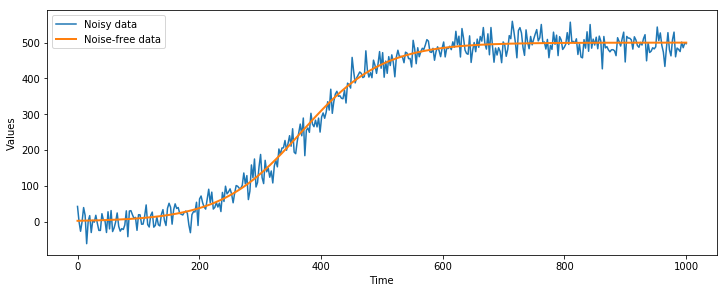

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0.5        0:00.0
2     9      0         0.333     0.333      0:00.0
3     12     0.25      0.25      0.25       0:00.0
20    63     0.0952    0.0476    0.19       0:00.1
40    123    0.0488    0.0244    0.146      0:00.1
60    183    0.0492    0.0164    0.0984     0:00.1
80    243    0.037     0.037     0.0864     0:00.1
100   303    0.0297    0.0297    0.0792     0:00.1
120   363    0.0248    0.0248    0.0661     0:00.1
140   423    0.0213    0.0213    0.0567     0:00.1
160   483    0.0311    0.0248    0.0497     0:00.2
180   543    0.0276    0.0221    0.0442     0:00.2
Initial phase completed.
200   603    0.0249    0.0249    0.039801   0:00.2
220   663    0.0452    0.0543    0.0498     0:00.2
240   723    0.108     0.0913    0.104      0:00.2
260   783   

3220  9663   0.222     0.225     0.232      0:02.4
3240  9723   0.222     0.226     0.233      0:02.4
3260  9783   0.222     0.224     0.234284   0:02.4
3280  9843   0.222     0.223     0.234      0:02.5
3300  9903   0.223     0.223     0.234      0:02.5
3320  9963   0.224     0.223     0.235      0:02.5
3340  10023  0.223     0.222     0.235      0:02.5
3360  10083  0.224     0.223     0.235      0:02.5
3380  10143  0.223     0.222     0.235      0:02.5
3400  10203  0.223     0.222     0.235      0:02.5
3420  10263  0.222     0.221865  0.234      0:02.6
3440  10323  0.222     0.222     0.233      0:02.6
3460  10383  0.222     0.222     0.233      0:02.6
3480  10443  0.223     0.222     0.232      0:02.6
3500  10503  0.223     0.223     0.233      0:02.6
3520  10563  0.222948  0.224     0.234      0:02.6
3540  10623  0.222536  0.224     0.234      0:02.6
3560  10683  0.223     0.224656  0.233      0:02.7
3580  10743  0.223     0.225     0.233      0:02.7
3600  10803  0.223     0.225   

6500  19503  0.226     0.23      0.231      0:04.8
6520  19563  0.226     0.23      0.231      0:04.8
6540  19623  0.225     0.23024   0.231      0:04.8
6560  19683  0.225423  0.23      0.231      0:04.8
6580  19743  0.225     0.230664  0.231      0:04.9
6600  19803  0.225     0.231     0.231      0:04.9
6620  19863  0.226     0.231     0.231      0:04.9
6640  19923  0.225     0.231     0.231441   0:04.9
6660  19983  0.225     0.231     0.231      0:04.9
6680  20043  0.225     0.231     0.231      0:04.9
6700  20103  0.225     0.231     0.231      0:04.9
6720  20163  0.225     0.231662  0.231      0:05.0
6740  20223  0.224     0.231     0.231      0:05.0
6760  20283  0.224     0.232     0.232      0:05.0
6780  20343  0.224     0.232     0.232      0:05.0
6800  20403  0.224     0.231     0.232      0:05.0
6820  20463  0.224     0.232     0.231491   0:05.0
6840  20523  0.223     0.231     0.231      0:05.0
6860  20583  0.224     0.232     0.232      0:05.1
6880  20643  0.224     0.232   

9820  29463  0.227     0.229     0.232      0:07.2
9840  29523  0.227     0.23      0.232      0:07.2
9860  29583  0.227     0.23      0.232      0:07.2
9880  29643  0.227     0.23      0.232      0:07.3
9900  29703  0.226     0.23      0.232      0:07.3
9920  29763  0.227     0.23      0.232      0:07.3
9940  29823  0.227     0.23      0.232371   0:07.3
9960  29883  0.227     0.229     0.232306   0:07.3
9980  29943  0.227     0.23      0.233      0:07.3
10000 30000  0.227     0.2297    0.2327     0:07.4
Halting: Maximum number of iterations (10000) reached.


In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

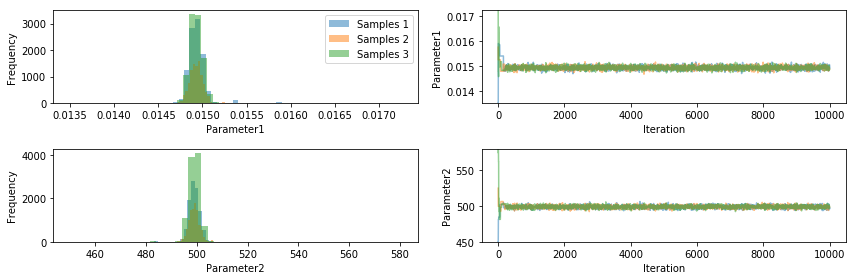

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

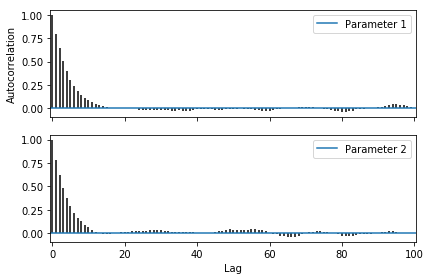

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

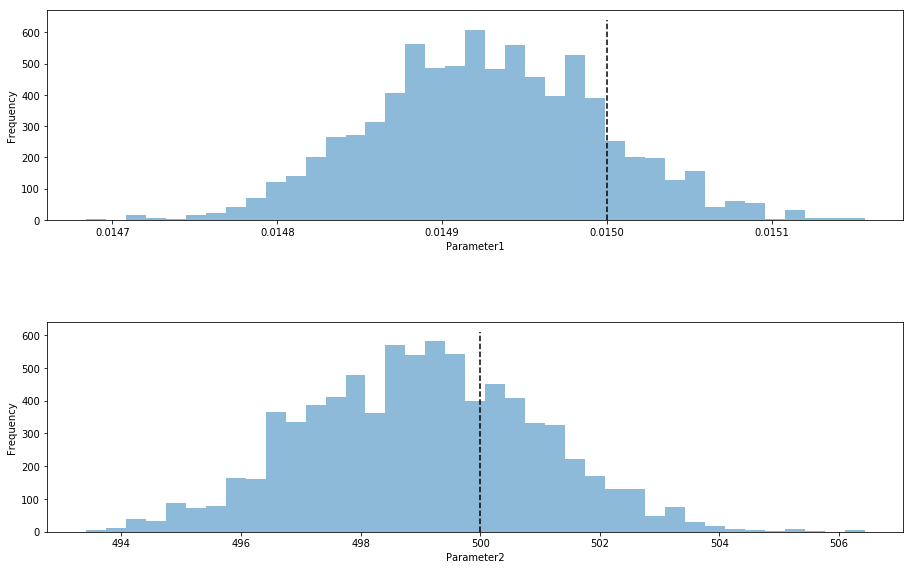

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

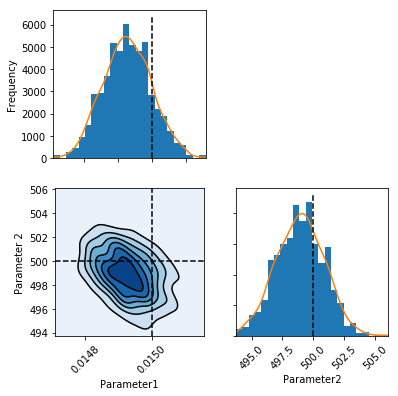

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

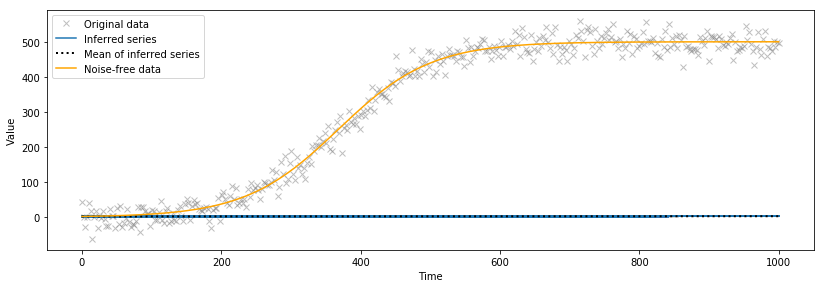

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

In [99]:
#
# Basic emulator artificial neural network (ANN)
#
# This file is part of PINTS (https://github.com/pints-team/pints/) which is
# released under the BSD 3-clause license. See accompanying LICENSE.md for
# copyright notice and full license details.
#
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints
import numpy as np
import tensorflow as tf
import keras
import copy
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import HDF5Matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class NeuralNetwork2(pints.ProblemLogLikelihood):
    """
    Abstract base class for emulators that are based on neural networks.
    Extends :class:`Emulator`.
    Parameters
    ----------
    x0
        An starting point in the parameter space.
    sigma0
        An optional (initial) covariance matrix, i.e., a guess of the
        covariance of the distribution to estimate, around ``x0``.
    """
    
    """
    *Extends:* :class:`LogPDF`
    Abstract class from which all emulators should inherit.
    An instance of the Emulator models given log-likelihood
    Arguments:
    ``log_likelihood``
        A :class:`LogPDF`, the likelihood distribution being emulated.
    ``X``
        N by n_paremeters matrix containing inputs for training data
    ``y``
        N by 1, target values for each input vector
    ``input_scaler``
        sklearn scalar type, don't pass class just the type.
        E.g. StandardScaler provides standardization.
    ``output_scaler``
        sklearn scaler class that will be applied to output
    """

    def __init__(self, problem, X, y, input_scaler=None, output_scaler=None):
        # Perform sanity checks for given data
        if not (isinstance(problem, pints.SingleOutputProblem) or isinstance(problem, pints.MultiOutputProblem)):
            raise ValueError("Given problem must extend SingleOutputProblem or MultiOutputProblem.")
        super(NeuralNetwork2, self).__init__(problem)

        # Store counts
        self._no = problem.n_outputs()
        self._np = problem.n_parameters()
        self._nt = problem.n_times()

        # check if dimensions are valid
        if X.ndim < 2:
            raise ValueError("Input should be 2 dimensional")
        X_r, X_c, X_t = X.shape
        if (X_c != self._n_parameters):
            raise ValueError("Input data should have", self._np, "features")

        # if given target array is 1d convert automatically
        if y.ndim == 1:
            y = y.reshape(len(y), 1)
        if y.ndim != 2:
            raise ValueError("Target array should be 2 dimensional (N, 1)")

        y_r, y_c = y.shape
        if y_c != 1:
            raise ValueError("Target array should only have 1 feature")
        if (X_r != y_r):
            raise ValueError("Input and target dimensions don't match")

        # Scale data for inputs and output
        self._X = copy.deepcopy(X)
        if input_scaler:
            self._input_scaler = {}
            for i in range(X.shape[1]):
                self._input_scaler[i] = MinMaxScaler()
                self._X[:, i, :] = self._input_scaler[i].fit_transform(X[:, i, :]) 
            #self._input_scaler.fit(X)
            #self._X = self._input_scaler.transform(X)

        self._output_scaler = output_scaler
        if output_scaler:
            self._output_scaler.fit(y)
            self._y = self._output_scaler.transform(y)
        else:
            self._y = copy.deepcopy(y)  # use a copy to prevent original data from changing

    def n_parameters(self):
        return self._np
    
    
class RescaledMetrics(keras.callbacks.Callback):
    def __init__(self, output_scaler):
        self._output_scaler = output_scaler

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # Predict log-likelihood using training data
        X_train, y_train = self.model.X_train, self.model.y_train
        y_hat_train = self.model.predict(X_train)
        
        # Predict log-likelihood using validation data
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_hat_val = self.model.predict(X_val)
        
        # Rescale predictions
        y_train = self._output_scaler.inverse_transform(y_train)
        y_hat_train = self._output_scaler.inverse_transform(y_hat_train)
        y_val = self._output_scaler.inverse_transform(y_val)
        y_hat_val = self._output_scaler.inverse_transform(y_hat_val)
        
        # Calculate metrics based on rescaled predictions
        train_mae = np.mean(np.abs(y_hat_train - y_train))
        train_mse = np.mean((y_hat_train - y_train)**2)
        val_mae = np.mean(np.abs(y_hat_val - y_val))
        val_mse = np.mean((y_hat_val - y_val)**2)
        
        # Store rescaled metrics
        logs["rescaled_mae"] = train_mae
        logs["rescaled_mse"] = train_mse
        logs["val_rescaled_mae"] = val_mae
        logs["val_rescaled_mse"] = val_mse
        return

    
class MultiLayerNN2(NeuralNetwork2):
    """
    Single layer neural network emulator.
    Extends :class:`NNEmulator`.
    """
    def __init__(self, problem, X, y, input_scaler=None, output_scaler=None):
        super(MultiLayerNN2, self).__init__(problem, X, y, input_scaler, output_scaler)
        self._model = Sequential()


    def __call__(self, xx):
        """ Additional **kwargs can be provided to Keras's predict method. """
        x = np.array(copy.deepcopy(xx)).reshape((2, self.n_parameters()))
        if self._input_scaler:
            for i in range(x.shape[0]):
                x[i, :] = self._input_scaler[i].transform(x[i, :].reshape(1, -1)) 
            #x = self._input_scaler.transform(x)
        x1, x2 = x.shape
        y = self._model.predict([x.reshape(1, x1, x2)])
        if self._output_scaler:
            y = self._output_scaler.inverse_transform(y)
        return y
    

    def set_parameters(self, layers=6, neurons=64, hidden_activation='relu', activation='sigmoid', 
                       learning_rate=0.001, 
                       regularize=True, loss='mse', metrics=['mae']):
        """ Provide parameters to compile the model. """
        initializer = tf.keras.initializers.he_uniform(seed=1234)
        k = int(layers/2)
        if regularize:
            regularizer=tf.keras.regularizers.l2(0.01)
        else: 
            regularizer=None
        if hidden_activation == "relu":
            hidden_activation = tf.keras.layers.LeakyReLU(alpha=0.1) 
        # Input layer   
        self._model.add(Flatten())
        self._model.add(Dense(neurons,
                        activation=hidden_activation,
                        input_dim=self._np,
                        kernel_initializer=initializer,
                        kernel_regularizer=regularizer
        ))
        # Hidden layers
        for n in range(1, k):    
            self._model.add(Dense(neurons*(2**n),
                            activation=hidden_activation,
                            kernel_initializer=initializer,                  
                            kernel_regularizer=regularizer
            ))
        for n in range(k-2, -1, -1):    
            self._model.add(Dense(neurons*(2**n),
                            activation=hidden_activation,
                            kernel_initializer=initializer,                  
                            kernel_regularizer=regularizer
            ))
        # Output layer
        self._model.add(Dense(1, activation=activation))
        
        #opt = keras.optimizers.SGD(learning_rate, momentum=0.9)
        opt = keras.optimizers.Adam(learning_rate)
        self._model.compile(
            loss="mae",
            optimizer=opt,
            metrics=metrics
        )

    def fit(self, epochs=50, batch_size=32, X_val=None, y_val=None, verbose=0):
        """ Training neural network and return history. """
        if self._input_scaler and X_val is not None:
            for i in range(X_val.shape[1]):
                X_val[:, i, :] = self._input_scaler[i].transform(X_val[:, i, :]) 
            #X_val = self._input_scaler.transform(X_val)
        if self._output_scaler and y_val is not None:
            y_val = np.array(y_val).reshape((len(y_val),1))
            y_val = self._output_scaler.transform(y_val)  
        # Create a callback object to compute rescaled metrics
        metrics_calculater = RescaledMetrics(self._output_scaler)
        # Create a callback that saves the model's weights
        checkpoint_path = "checkpoints/epoch_{epoch:02d}.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        weights_saver = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=0)
        # Create a callback for early stopping if no progress is made
        early_stopper = EarlyStopping(monitor='val_mean_absolute_error',min_delta=0,patience=5,verbose=0,mode='auto')
        plateau_reducer = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.3, patience=50)
        
        self._model.X_train = self._X
        self._model.y_train = self._y
        self._history = self._model.fit(self._X,
                                        self._y,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        callbacks=[early_stopper,
                                                  weights_saver,
                                                  metrics_calculater],
                                        shuffle=True,
                                        validation_data=(X_val, y_val),
                                        verbose=verbose
        )
        return self._history

    def summary(self):
        return self._model.summary()

    def evaluate(self, X_test, y_test, **kwargs):
        """ Uses Keras's evaluate() method, so can provide additional paramaters. """
        if self._input_scaler:
            X_test = self._input_scaler.transform(X_test)
        if self._output_scaler:
            y_test = self._output_scaler.inverse_transform(y_test)  
        return self._model.evaluate(X_test, y_test, **kwargs)

    def get_model(self):
        """ Return model. """
        return self._model

    def get_model_history(self):
        """ Returns the log marginal likelihood of the model. """
        assert hasattr(self, "_history"), "Must first train NN"
        return self._history

    def name(self):
        """ See :meth:`pints.NNEmulator.name()`. """
        return 'Multi-layer neural network'



In [27]:
n_parameters = 2
sigma = np.array(start_parameters) * 5e-05
sigma = np.array(sigma)
if np.product(sigma.shape) == n_parameters:
    # Convert from 1d array
    sigma = sigma.reshape((n_parameters,))
    sigma = np.diag(sigma)
else:
    # Check if 2d matrix of correct size
    sigma = sigma.reshape((n_parameters, n_parameters))
sigma

array([[3.75e-05, 0.00e+00],
       [0.00e+00, 5.00e-05]])

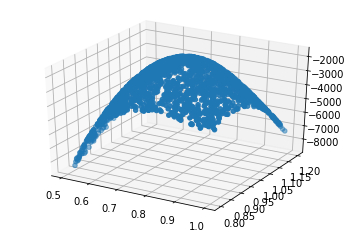

array([[[0.84353595, 0.93088844],
        [0.84242199, 0.93938406]],

       [[0.67223644, 0.92366178],
        [0.68020448, 0.91673586]],

       [[0.68598206, 0.83795799],
        [0.68850398, 0.83024144]],

       ...,

       [[0.52533474, 1.11384184],
        [0.52988238, 1.11542262]],

       [[0.88866995, 1.15562123],
        [0.87823967, 1.14813251]],

       [[0.88906348, 1.02897026],
        [0.89719836, 1.01685279]]])

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
input_proposals = [np.random.multivariate_normal(current, sigma) for current in input_parameters]
current_likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
proposed_likelihoods = np.apply_along_axis(log_likelihood, 1, input_proposals)
inputs = np.array([(curr, prop) for curr, prop in zip(input_parameters, input_proposals)])
outputs = np.array([prop - curr for curr, prop in zip(current_likelihoods, proposed_likelihoods)])

likelihoods = current_likelihoods
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()
inputs

In [55]:
inputs[1][0][1]

0.9236617773524263

In [120]:
outputs

array([ 25.36237973,  30.91179068, -85.33411238, ..., 177.43799744,
       303.31405564,   5.56325664])

In [122]:
log_likelihood([0.84242199, 0.93938406]) - log_likelihood([0.84353595, 0.93088844])

25.362369518307787

In [100]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(inputs, outputs, test_size=0.3, random_state=0)
emu = MultiLayerNN2(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_74 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_75 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 65        
Total para

In [ ]:
[[0.68598206, 0.83795799],
        [0.68850398, 0.83024144]]

In [123]:
#test_x = np.array(([0.6, 0.8], [0.612, 0.809]))
#test_x = np.array(([0.68598206, 0.83795799], [0.68850398, 0.83024144]))
test_x = np.array(([0.7, 0.95], [0.71, 0.96]))

In [126]:
emu(test_x)

array([[0.9315569]], dtype=float32)

In [128]:
log_likelihood(test_x[1]) - log_likelihood(test_x[0])

108.09687450719389

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


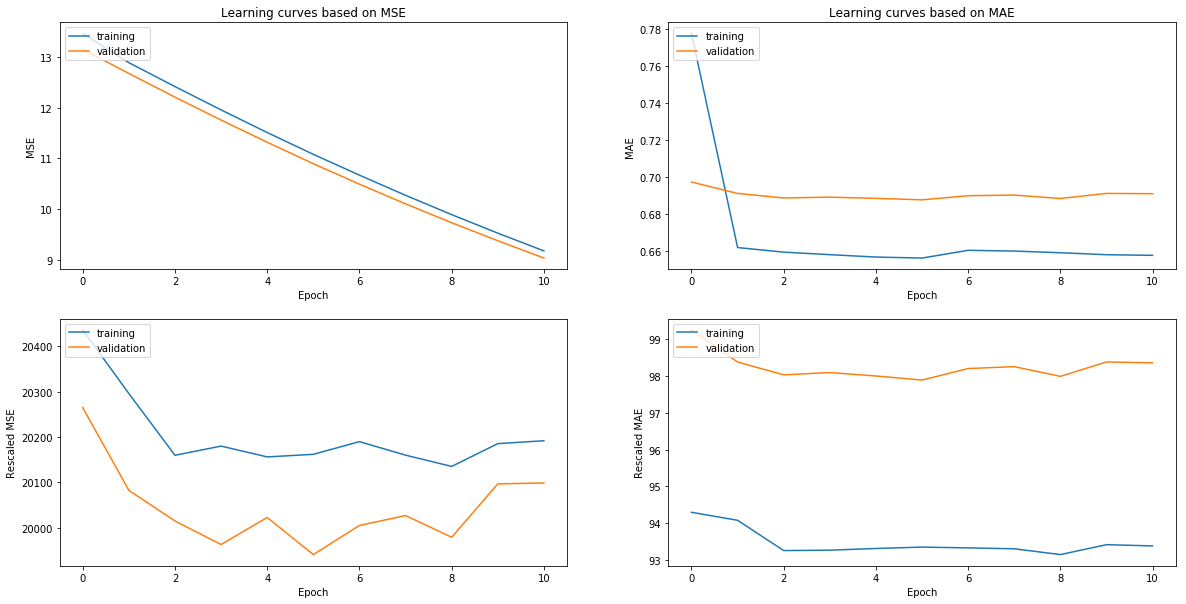

In [129]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [180]:
n_iterations = 1000
factor = 1.0
x0 = np.array(start_parameters) * factor
sigma0 = np.array(start_parameters) * 5e-05
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [181]:
xs = []
diffs = []
orig_rule = []
first_rule = []
second_rule = []
step1 = [0] * n_iterations
step2 = [0] * n_iterations
alphas = []
orig = [0] * n_iterations
    
# Run MCMC methods 
for n in range(0, n_iterations):
    if n == 0:
        # Current point and proposed point
        current = x0
        #current_log_pdf = log_posterior_emu(x0)
        #true_current_log_pdf = log_posterior(x0)
        proposed = None

        # Acceptance rate and error monitoring
        error = 0
        accepted1 = 0
        accepted2 = 0
        orig_accepted = 0

        # Check initial position
        x0 = pints.vector(x0)

        # Get number of parameters
        n_parameters = len(x0)

        # Check initial standard deviation
        if sigma0 is None:
            # Get representative parameter value for each parameter
            sigma0 = np.abs(x0)
            sigma0[sigma0 == 0] = 1
            # Use to create diagonal matrix
            sigma0 = np.diag(0.01 * sigma0)
        else:
            sigma0 = np.array(sigma0)
            if np.product(sigma0.shape) == n_parameters:
                # Convert from 1d array
                sigma0 = sigma0.reshape((n_parameters,))
                sigma0 = np.diag(sigma0)
            else:
                # Check if 2d matrix of correct size
                sigma0 = sigma0.reshape((n_parameters, n_parameters))

    # Ask- Propose new point
    #if proposed is None:
    proposed = np.random.multivariate_normal(current, sigma0)
    xx = [current, proposed]

    # Tell    
    # Calculate logpdfs
    fx = log_posterior_emu(xx)
    true_fx = log_posterior(proposed) - log_posterior(current)
    error += np.abs((true_fx - fx) / true_fx)

    # Check if the proposed point can be accepted using the emulator
    if np.isfinite(fx):
        # Step 1 - Initial reject step:
        u1 = np.log(np.random.uniform(0, 1))
        #alpha1 = min(0, (fx - current_log_pdf)[0][0]) # either alpha1 or alpha2 must be 0
        alpha1 = min(0, fx[0][0])
        if alpha1 > u1:
            accepted1 += 1
            step1[n] = 1
            # Step 2 - Metropolis step:
            u2 = np.log(np.random.uniform(0, 1))
            #alpha2 = min(0, (current_log_pdf - fx)[0][0])
            alpha2 = min(0, -fx[0][0])
            #if ((true_fx + alpha2) - (true_current_log_pdf + alpha1)) > u2:
            if (true_fx + alpha2 - alpha1) > u2:
                accepted2 += 1 
                step2[n] = 1

    # Check if the proposed point can be accepted using standard MCMC
    if np.isfinite(fx):
        # Step 1 - Initial reject step:
        u = np.log(np.random.uniform(0, 1))
        alpha = log_posterior(proposed) - log_posterior(current)
        if alpha > u:
            orig_accepted += 1
            orig[n] = 1

    # Clear proposal
    xs.append(proposed)
    proposed = None
    
    # Compute difference between emulator and true model
    diff = true_fx - fx
    diffs.append(diff[0][0])
    orig_rule.append(alpha)
    first_rule.append(alpha1)
    if step1[n] == 1:
        second_rule.append((true_fx + alpha2 - alpha1))
        alphas.append(alpha2)
    else:
        second_rule.append(-200)
        alphas.append(0)


# Compute acceptance rates
mae = error[0][0] / n_iterations
acceptances = accepted2 / n_iterations
acceptances1 = accepted1 / n_iterations
acceptances2 = accepted2 / accepted1
orig_acceptances = orig_accepted / n_iterations


In [182]:
print("Overall:", acceptances)
print("1st-step:", acceptances1)
print("2nd-step:", acceptances2)
print("Original:", orig_acceptances)


Overall: 0.0
1st-step: 1.0
2nd-step: 0.0
Original: 0.344


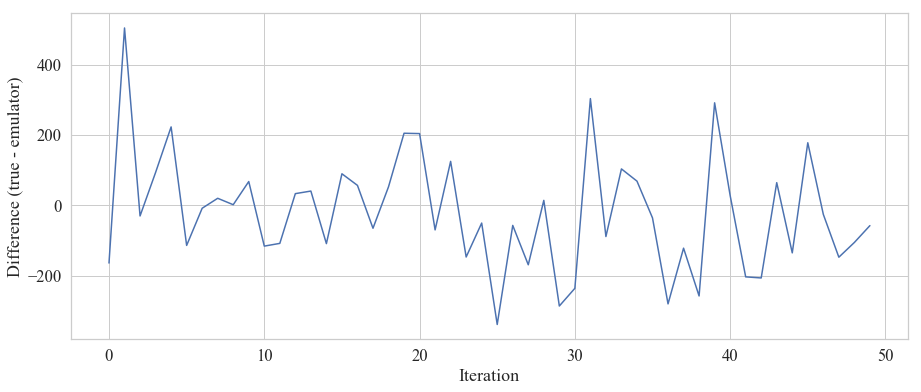

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})

fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Difference (true - emulator)')
ax.plot(diffs[:50])
plt.show()

#fig.savefig("figures/gradients/differences-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [176]:
step_sum = [s1 + s2 for (s1, s2) in zip(step1, step2)]
step_sum1 = [s - 1 if s>0 else s for s in step_sum]
sum([s == o for (s, o) in zip(step_sum1, orig)][:50])

49

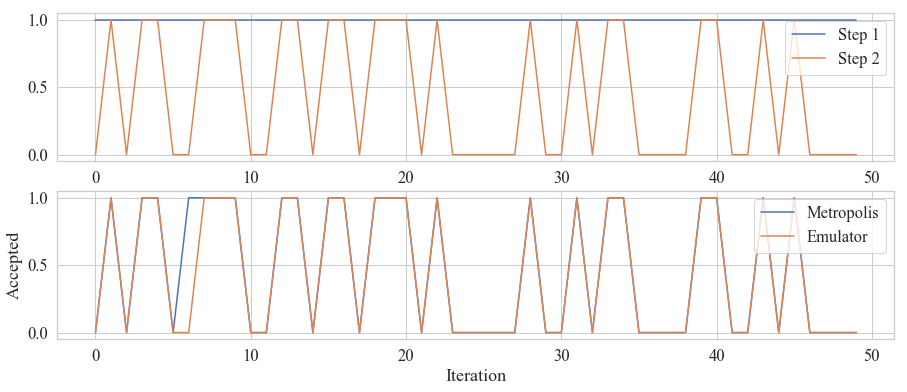

In [177]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,6))
plt.xlabel('Iteration')
plt.ylabel('Accepted')
ax1.plot(step1[:50], label='Step 1')
ax1.plot(step2[:50], label='Step 2')
ax1.legend()
ax2.plot(orig[:50], label='Metropolis')
ax2.plot(step_sum1[:50], label='Emulator')
plt.legend()
plt.show()

#fig.savefig("figures/alphas/acceptances-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [178]:
first_rule[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

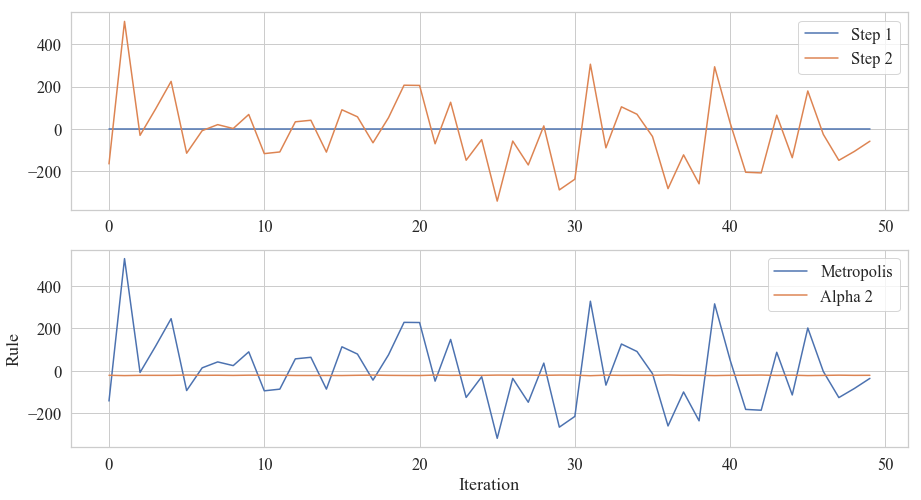

In [179]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,8))
plt.xlabel('Iteration')
plt.ylabel('Rule')
ax1.plot(first_rule[:50], label='Step 1')
ax1.plot(second_rule[:50], label='Step 2')
ax1.legend()
ax2.plot(orig_rule[:50], label='Metropolis')
ax2.plot(alphas[:50], label='Alpha 2')
ax2.legend()
plt.show()

#fig.savefig("figures/gradients/alphas-"+str(factor)+".png", bbox_inches='tight', dpi=200)

In [130]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.9
fontsize=16
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(r_grid, k_grid, emu_prediction, cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.25)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ["True log-likelihood", "NN emulator log-likelihood"])

plt.show()
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

ValueError: cannot reshape array of size 2 into shape (2,2)

In [ ]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
print(emu_prediction)

In [ ]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [ ]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

In [ ]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

In [ ]:
pints.plot.trace(chains_emu)
plt.show()

In [ ]:
pints.plot.trace(chains)
plt.show()

In [ ]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

In [ ]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

In [ ]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

In [ ]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

In [ ]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [ ]:
chain_emu

In [ ]:
# Create grid of parameters
x = [p[0] for p in chain_rescaled]
y = [p[1] for p in chain_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-3
#sigma0 = [0.1*0.75, 0.1] #np.abs(true_parameters) * 5e-3
#sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]
sigma0 = np.array(start_parameters) * 5e-05

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5
#sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
ac_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(ac_chains)

# Discard warm up
ac_chains_thinned = ac_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(ac_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(ac_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
metropolis_chains.shape

In [ ]:
metropolis_chains[0][:10]

In [ ]:
emulated_chains[0][:10]

In [ ]:
fig, axes = pints.plot.histogram([emulated_chains_thinned[0], metropolis_chains_thinned[0]], ref_parameters=start_parameters, sample_names=["Emulator", "MCMC", "2-Step procedure"])
fig.set_size_inches(14, 9)
plt.show()